# Person Detection Training

In this notebook, we are going to use transfer learning to update a pre-trained [Yolo-Fastest](https://github.com/dog-qiuqiu/Yolo-Fastest) model to identify people in an image. We will retrain the model using a preexisting [dataset from Roboflow](https://universe.roboflow.com/titulacin/person-detection-9a6mk).

In Google Colab, select **File > Open notebook** then select the **Upload** tab. Select this file to open it in Colab.

Press **shift + enter** to execute each cell in order. Make sure you stop and read each text section, as there are some manual steps you will need to perform (e.g. upload dataset).

> **IMPORTANT!** We are downloading our dataset from [Roboflow](https://roboflow.com/). To do that, you will need to sign up for a free account, go to your account and get your API key. Update the `ROBOFLOW_API_KEY` value with your personal API key.

In [1]:
# Install specific versions of the packages
!python3 -m pip install \
    opencv-python=='4.13.0.90' \
    matplotlib=='3.10.0' \
    numpy=='2.0.2' \
    onnxscript=='0.5.7' \
    pandas=='2.2.2' \
    Pillow=='11.3.0' \
    roboflow=='1.2.13' \
    torch=='2.9.0'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.4/693.4 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 83.0 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.13.0.90
    Uninstalling opencv-python-headless-4.13.0.90:
      Successfully uninstalled opencv-python-headless-4.13.0.90
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11


In [2]:
# Import standard libraries
import os
from pathlib import Path
import random
import shutil
import sys
import types
import urllib.request
import zipfile

# Import third-party libraries
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
from PIL import Image
from roboflow import Roboflow
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [3]:
# Print out the versions of the libraries
print(f"OpenCV version: {cv2.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Pillow version: {Image.__version__}")
print(f"PyTorch version: {torch.__version__}")

OpenCV version: 4.10.0
Matplotlib version: 3.10.0
NumPy version: 2.0.2
Pandas version: 2.2.2
Pillow version: 11.3.0
PyTorch version: 2.9.0+cu126


In [4]:
# IMPORTANT! Update this with your Roboflow API key
ROBOFLOW_API_KEY = "paMbiEJKN9RxCvMqX0ji"

In [136]:
# General settings
SEED = 42

# Dataset settings
ROBOFLOW_WORKSPACE = "titulacin"
ROBOFLOW_PROJECT = "person-detection-9a6mk"
ROBOFLOW_PROJECT_VERSION = 16
ROBOFLOW_DATASET_TYPE = "yolov5"
DATASET_PATH = Path("/content/dataset")
CONFIG_PATH = Path("/content/yolo_config")

# Class names (see Roboflow project for names)
CLASS_NAMES = ["person"]
NUM_CLASSES = len(CLASS_NAMES)

# Pre-trained model settings
REPO_URL = "https://github.com/dog-qiuqiu/Yolo-Fastest/archive/refs/tags/v.1.1.0.zip"
REPO_ZIP_PATH = Path("/content/Yolo-Fastest.zip")
REPO_PATH = Path("/content/Yolo-Fastest")
WEIGHTS_PATH = REPO_PATH
MODEL_CFG_PATH = REPO_PATH / "ModelZoo/yolo-fastest-1.1_coco/yolo-fastest-1.1.cfg"
MODEL_WEIGHTS_PATH = REPO_PATH / "ModelZoo/yolo-fastest-1.1_coco/yolo-fastest-1.1.weights"
MODIFIED_CFG_PATH = Path("/content/yolo-fastest-1.1_192_no_dropout.cfg")

# Darknet to PyTorch converter script
CONVERTER_SCRIPT_URL = "https://raw.githubusercontent.com/ShawnHymel/intro-to-edge-ai-and-cv-with-renesas/main/scripts/yolo_fastest_to_pytorch.py"
CONVERTER_SCRIPT_PATH = Path("/content/yolo_fastest_to_pytorch.py")

# Utilities script
UTILS_SCRIPT_URL = "https://raw.githubusercontent.com/ShawnHymel/intro-to-edge-ai-and-cv-with-renesas/main/scripts/yolo_fastest_utils.py"
UTILS_SCRIPT_PATH = Path("/content/yolo_fastest_utils.py")

# Loss calculation script
LOSS_SCRIPT_URL = "https://raw.githubusercontent.com/ShawnHymel/intro-to-edge-ai-and-cv-with-renesas/main/scripts/yolo_fastest_loss.py"
LOSS_SCRIPT_PATH = Path("/content/yolo_fastest_loss.py")

# Image preprocessing settings
IMG_WIDTH = 192
IMG_HEIGHT = 192

# Model settings
NUM_ANCHORS = 3
NUM_CLASSES = 1
NEW_FILTERS = NUM_ANCHORS * (5 + NUM_CLASSES)  # 3 * 6 = 18

# Model update settings
NUM_CLASSES = 1
BATCH_SIZE = 32
NUM_WORKERS = 2 # Number of parallel processes for loading data

# Freeze settings (set to True to freeze)
FREEZE_BACKBONE = False
FREEZE_NECK = False

# Training settings
NUM_EPOCHS = 30
LEARNING_RATE = 0.0001
BEST_MODEL_PATH = Path("/content/best_model.pth")

# PyTorch export settings
PYTORCH_PATH = Path("/content/model.pt")

# ONNX export settings
ONNX_OPSET_VERSION = 18
ONNX_PATH = Path("/content/model.onnx")

# Calibration data settings
NUM_CALIB_SAMPLES = 20
CALIB_NPZ_PATH = Path("/content/calibration_data.npz")

# LiteRT (tflite) export settings
TFLITE_SCRIPT_URL = "https://raw.githubusercontent.com/ShawnHymel/intro-to-edge-ai-and-cv-with-renesas/main/scripts/yolo_fastest_to_tflite.py"
TFLITE_SCRIPT_PATH = Path("/content/yolo_fastest_to_tflite.py")
TFLITE_PATH = Path("/content/model.tflite")

# Test sample settings
TEST_SAMPLE_NPZ_PATH = Path("/content/test_sample.npz")
TEST_SAMPLE_H_PATH = Path("/content/test_sample.h")

In [6]:
# Set random seeds for reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

In [7]:
# Define the target compute device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Prepare Dataset

Rather than create our own (which is very time consuming), we will use an existing dataset to retrain the model.

We first download and unzip the dataset. After that, we covert the annotations to YOLO-style (normalized bounding box information in a .txt file for each image). Then, we create a few text files in *yolo_config/* that lists the classes and gives the location of each image file.

In [8]:
# Download dataset from Roboflow
rf = Roboflow(api_key=ROBOFLOW_API_KEY)
project = rf.workspace(ROBOFLOW_WORKSPACE).project(ROBOFLOW_PROJECT)
version = project.version(ROBOFLOW_PROJECT_VERSION)
dataset = version.download(ROBOFLOW_DATASET_TYPE, location=str(DATASET_PATH))

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to /content/dataset in yolov5pytorch:: 100%|██████████| 10978/10978 [00:03<00:00, 3630.34it/s]


In [9]:
# Build image path lists directly from the Roboflow directory structure
CONFIG_PATH.mkdir(parents=True, exist_ok=True)

# Define dataset splits
splits = {'train': 'train', 'val': 'valid', 'test': 'test'}
all_paths = {}

# Construct YOLO config files
for split_name, folder_name in splits.items():
    img_dir = DATASET_PATH / folder_name / 'images'
    paths = sorted([str(p) for p in img_dir.iterdir()
                    if p.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp']])
    all_paths[split_name] = paths

    # Write list file
    txt_file = CONFIG_PATH / f"{split_name}.txt"
    with open(txt_file, 'w') as f:
        f.write('\n'.join(paths))
    print(f"Created: {txt_file} ({len(paths)} images)")

# Write classes.names
names_file = CONFIG_PATH / "classes.names"
with open(names_file, 'w') as f:
    for name in CLASS_NAMES:
        f.write(f"{name}\n")
print(f"Created: {names_file} ({len(CLASS_NAMES)} classes)")

Created: /content/yolo_config/train.txt (4407 images)
Created: /content/yolo_config/val.txt (1071 images)
Created: /content/yolo_config/test.txt (5 images)
Created: /content/yolo_config/classes.names (1 classes)


## Create DataLoaders

We need to create loaders for our dataset.

In [10]:
class YoloDataset(Dataset):
    """YOLO-format dataset loader using image list file."""

    def __init__(self, list_file, img_size=192, augment=False):
        self.img_size = img_size
        self.augment = augment

        # Read image from file
        with open(list_file, 'r') as f:
            self.img_files = [Path(line.strip()) for line in f if line.strip()]

        print(f"Loaded {len(self.img_files)} images from {list_file}")

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        # Load image
        img_path = self.img_files[idx]
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        orig_h, orig_w = img.shape[:2]

        # Load labels (labels are in a parallel 'labels/' folder)
        label_path = img_path.parent.parent / 'labels' / img_path.with_suffix('.txt').name
        if label_path.exists() and label_path.stat().st_size > 0:
            labels = np.loadtxt(str(label_path)).reshape(-1, 5).copy()
        else:
            labels = np.zeros((0, 5))

        # Apply augmentation before crop/resize
        if self.augment and len(labels) > 0:
            img, labels = self.apply_augmentation(img, labels)

        # Center crop to square and adjust labels
        img, labels = self.center_crop(img, labels)

        # Resize cropped square to target size
        img = cv2.resize(img, (self.img_size, self.img_size))

        # Normalize to [0, 1] and convert to CHW
        img = img.astype(np.float32) / 255.0
        img = torch.from_numpy(img).permute(2, 0, 1)

        if len(labels) > 0:
            labels = torch.from_numpy(labels).float()
        else:
            labels = torch.zeros((0, 5))

        return img, labels

    def center_crop(self, img, labels):
        """Center crop image to square and adjust bounding boxes."""
        h, w = img.shape[:2]
        crop_size = min(h, w)
        x_offset = (w - crop_size) // 2
        y_offset = (h - crop_size) // 2

        # Crop image
        img = img[y_offset:y_offset + crop_size, x_offset:x_offset + crop_size]

        if len(labels) == 0:
            return img, labels

        # Convert normalized coords to pixel coords
        cx = labels[:, 1] * w
        cy = labels[:, 2] * h
        bw = labels[:, 3] * w
        bh = labels[:, 4] * h

        # Shift to crop-relative pixel coords
        cx -= x_offset
        cy -= y_offset

        # Convert to x1, y1, x2, y2 for clipping
        x1 = cx - bw / 2
        y1 = cy - bh / 2
        x2 = cx + bw / 2
        y2 = cy + bh / 2

        # Clip to crop boundaries
        x1 = np.clip(x1, 0, crop_size)
        y1 = np.clip(y1, 0, crop_size)
        x2 = np.clip(x2, 0, crop_size)
        y2 = np.clip(y2, 0, crop_size)

        # Compute clipped box dimensions
        clipped_w = x2 - x1
        clipped_h = y2 - y1
        orig_area = bw * bh

        # Keep boxes that retain at least 30% of their original area
        keep = (clipped_w > 0) & (clipped_h > 0)
        keep = keep & ((clipped_w * clipped_h) / (orig_area + 1e-6) > 0.3)

        if not np.any(keep):
            return img, np.zeros((0, 5))

        # Rebuild labels in normalized YOLO format relative to crop
        new_cx = ((x1[keep] + x2[keep]) / 2) / crop_size
        new_cy = ((y1[keep] + y2[keep]) / 2) / crop_size
        new_w = clipped_w[keep] / crop_size
        new_h = clipped_h[keep] / crop_size

        new_labels = np.stack([labels[keep, 0], new_cx, new_cy, new_w, new_h], axis=1)

        return img, new_labels

    def apply_augmentation(self, img, labels):
        """Apply random augmentations."""
        # Random horizontal flip (50% chance)
        if random.random() > 0.5:
            img = cv2.flip(img, 1)
            labels[:, 1] = 1.0 - labels[:, 1]  # Flip x_center

        # Random brightness adjustment
        if random.random() > 0.5:
            factor = 0.7 + random.random() * 0.6  # 0.7 to 1.3
            img = np.clip(img * factor, 0, 255).astype(np.uint8)

        # Random contrast adjustment
        if random.random() > 0.5:
            factor = 0.7 + random.random() * 0.6  # 0.7 to 1.3
            mean = img.mean()
            img = np.clip((img - mean) * factor + mean, 0, 255).astype(np.uint8)

        # Random saturation adjustment
        if random.random() > 0.5:
            img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float32)
            img_hsv[:, :, 1] *= 0.7 + random.random() * 0.6
            img_hsv[:, :, 1] = np.clip(img_hsv[:, :, 1], 0, 255)
            img = cv2.cvtColor(img_hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)

        return img, labels

In [11]:
def collate_fn(batch):
    """Collate function for variable-length labels."""
    imgs, labels = zip(*batch)

    # Stack images
    imgs = torch.stack(imgs, dim=0)

    # Add batch index to labels and concatenate
    batch_labels = []
    for i, label in enumerate(labels):
        if len(label) > 0:
            # Add batch index as first column
            batch_idx = torch.full((len(label), 1), i)
            batch_labels.append(torch.cat([batch_idx, label], dim=1))

    if batch_labels:
        labels = torch.cat(batch_labels, dim=0)  # [N, 6]: batch_idx, class, x, y, w, h
    else:
        labels = torch.zeros((0, 6))

    return imgs, labels

In [12]:
# Create datasets
train_dataset = YoloDataset(CONFIG_PATH / 'train.txt', img_size=IMG_HEIGHT, augment=True)
val_dataset = YoloDataset(CONFIG_PATH / 'val.txt', img_size=IMG_HEIGHT, augment=False)
test_dataset = YoloDataset(CONFIG_PATH / 'test.txt', img_size=IMG_HEIGHT, augment=False)

Loaded 4407 images from /content/yolo_config/train.txt
Loaded 1071 images from /content/yolo_config/val.txt
Loaded 5 images from /content/yolo_config/test.txt


In [13]:
# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=True,
    collate_fn=collate_fn
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=collate_fn
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if device.type == 'cuda' else False,
    collate_fn=collate_fn
)

print(f"Train: {len(train_loader)} batches")
print(f"Val: {len(val_loader)} batches")
print(f"Test: {len(test_loader)} batches")

Train: 137 batches
Val: 34 batches
Test: 1 batches


In [14]:
# Get one batch and verify details
imgs, labels = next(iter(train_loader))
print(f"Images: {imgs.shape}")
print(f"Labels: {labels.shape}")

Images: torch.Size([32, 3, 192, 192])
Labels: torch.Size([64, 6])


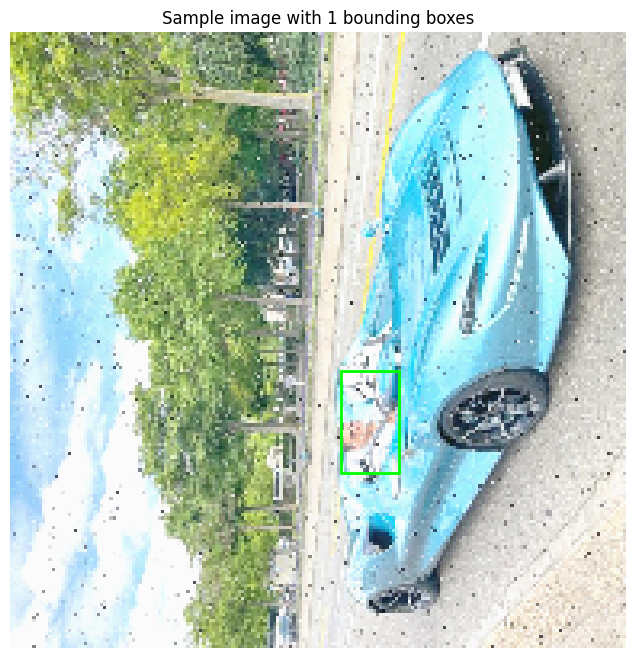

In [15]:
# Pick an index in the batch
idx = 9

# Get an image and its labels
img = imgs[idx].permute(1, 2, 0).numpy()  # CHW -> HWC, range [0, 1]
img_labels = labels[labels[:, 0] == idx]

# Create plots
fig, ax = plt.subplots(1, figsize=(8, 8))

# Option 1: Display float image directly (matplotlib handles [0, 1] range)
ax.imshow(img)

# Option 2: Convert to uint8 properly
# ax.imshow((img * 255).astype('uint8'))

# Draw bounding boxes
for label in img_labels:
    # Calculate box coordinates
    _, cls, cx, cy, w, h = label
    x = (cx - w/2) * IMG_WIDTH
    y = (cy - h/2) * IMG_HEIGHT
    width = w * IMG_WIDTH
    height = h * IMG_HEIGHT

    # Add green rectangle for bounding box
    rect = patches.Rectangle(
        (x, y),
        width,
        height,
        linewidth=2,
        edgecolor='lime',
        facecolor='none')
    ax.add_patch(rect)

# Show image info
ax.set_title(f"Sample image with {len(img_labels)} bounding boxes")
ax.axis('off')
plt.show()

## Prepare Model

The original Yolo-Fastest was built using the [Darknet](https://github.com/pjreddie/darknet) framework. We need to download the Yolo-Fastest repo, convert the model to PyTorch, and load the preexisting weights.

In [16]:
# Download the model repo (we need the model architecture and weights)
if not REPO_PATH.exists():
    !curl -L -o {REPO_ZIP_PATH} {REPO_URL}

    # Extract and rename to consistent path
    with zipfile.ZipFile(REPO_ZIP_PATH, 'r') as zip_ref:
        top_folder = zip_ref.namelist()[0].split('/')[0]
        zip_ref.extractall(REPO_PATH.parent)

    # Rename extracted folder to desired name
    extracted_path = REPO_PATH.parent / top_folder
    extracted_path.rename(REPO_PATH)
    print(f"Downloaded and extracted to {REPO_PATH}")
else:
    print(f"Repo already exists at {REPO_PATH}, skipping download")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 22.3M    0 22.3M    0     0   9.9M      0 --:--:--  0:00:02 --:--:-- 20.4M
Downloaded and extracted to /content/Yolo-Fastest


In [17]:
# Read the original config
with open(MODEL_CFG_PATH, 'r') as f:
    content = f.read()

# Change input size strings in config
new_content = content.replace("width=320", f"width={IMG_WIDTH}")
new_content = new_content.replace("height=320", f"height={IMG_HEIGHT}")

# Save modified config
with open(MODIFIED_CFG_PATH, 'w') as f:
    f.write(new_content)

# Verify changes
with open(MODIFIED_CFG_PATH, 'r') as f:
    first_lines = ''.join(f.readlines()[:15])
print(f"First lines of modified config:\n{first_lines}")

First lines of modified config:
[net]
batch=32
subdivisions=1
width=192
height=192
channels=3
momentum=0.949
decay=0.0005
angle=0
saturation=1.5
exposure=1.5
hue=.1


learning_rate=0.001



In [18]:
# Download converter script
urllib.request.urlretrieve(CONVERTER_SCRIPT_URL, CONVERTER_SCRIPT_PATH)
print(f"Downloaded converter script to {CONVERTER_SCRIPT_PATH}")

# Import classes and functions from our converter script
from yolo_fastest_to_pytorch import YoloFastest, ConvNoBN


Downloaded converter script to /content/yolo_fastest_to_pytorch.py


In [19]:
# Build model
model = YoloFastest(str(MODIFIED_CFG_PATH), input_size=IMG_HEIGHT)
print(f"Model built! Parameters: {sum(p.numel() for p in model.parameters()):,}")

# Load weights
model.load_darknet_weights(str(MODEL_WEIGHTS_PATH))

# Test forward pass
model.eval()
with torch.no_grad():
    dummy = torch.randn(1, 3, IMG_HEIGHT, IMG_WIDTH)
    outputs = model(dummy)
    print(f"Output shapes: {[o.shape for o in outputs]}")

Model built! Parameters: 332,798
Weights file contains 346062 values
Loaded 346062 / 346062 weights
Output shapes: [torch.Size([1, 255, 6, 6]), torch.Size([1, 255, 12, 12])]


## Replace Detection Heads

We need to replace the detection heads (final layers that predict one of 80 COCO classes by default) with custom layers that predict our 1 class ("person").

YOLO-Fastest has 2 detection heads that output predictions on two different grids (a coarse 6x6 grid and a finer 12x12 grid). Each grid cell contains 3 anchor points where an object might appear (anchors are predefined bounding boxes with different aspect ratios). The output of each detection head is a tensor with shape `[batch, channels, grid_height, grid_width]` where:

* `batch`: number of images. For inference, this will be 1.
* `channels`: 18 values representing 3 anchors with 6 predictions per anchor:
  * `tx, ty`: box center offset (relative to grid cell)
  * `tw, th`: box width/height scaling (relative to anchor size)
  * `obj`: objectness score (confidence that an object exists)
  * `cls`: class probability ("person")
* `grid_height`: number of rows of cells
* `grid_width`: number of columns of cells

The original COCO detection heads output 255 channels (3 anchors × 85 values, where 85 = 4 box + 1 obj + 80 classes). We replace these with heads that output 18 channels (3 anchors × 6 values, where 6 = 4 box + 1 obj + 1 class).

We should expect the output of the coarse detection head to have the shape `[1, 18, 6, 6]` and the output of the finer detection head to have the shape `[1, 18, 12, 12]`.

In [20]:
def find_detection_heads(model):
    """Find indices of conv layers immediately before yolo layers."""
    head_indices = []
    layer_idx = 0

    for i, block in enumerate(model.blocks):
        if block['type'] == 'net':
            continue

        if block['type'] == 'yolo':
            # The conv layer before this yolo is a detection head
            # Search backwards for the most recent conv
            search_idx = layer_idx - 1
            while search_idx >= 0:
                # Check the block type at this index
                block_idx = 0
                for b in model.blocks:
                    if b['type'] == 'net':
                        continue
                    if block_idx == search_idx:
                        if b['type'] == 'convolutional':
                            head_indices.append(search_idx)
                        break
                    block_idx += 1
                break

        layer_idx += 1

    return head_indices

In [21]:
# Find detection head layers programmatically
head_indices = find_detection_heads(model)
print(f"Detection head layer indices: {head_indices}")

Detection head layer indices: [120, 129]


In [22]:
# Replace detection heads with our 1-class detection heads
for idx in head_indices:
    old_conv = model.module_list[idx].conv
    model.module_list[idx] = ConvNoBN(
        in_ch=old_conv.in_channels,
        out_ch=NEW_FILTERS,
        kernel=old_conv.kernel_size[0],
        stride=old_conv.stride[0],
        pad=old_conv.padding[0],
        activation='linear'
    )

# Verify new output shapes
model.eval()
with torch.no_grad():
    dummy = torch.randn(1, 3, IMG_HEIGHT, IMG_WIDTH)
    outputs = model(dummy)
    print(f"New output shapes: {[o.shape for o in outputs]}")

New output shapes: [torch.Size([1, 18, 6, 6]), torch.Size([1, 18, 12, 12])]


In [23]:
# Move model to device
model = model.to(device)

## Replace Leaky ReLU with ReLU6

The Yolo-Fastest model uses [Leaky ReLU](https://docs.pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html) activation functions, which can be tricky for the RUHMI framework to convert to NPU code. To avoid any compilation issues later, we replace all the *Leaky ReLU* functions with [ReLU6](https://docs.pytorch.org/docs/stable/generated/torch.nn.ReLU6.html) functions (which essentially clamps inputs to `[0, 6]`). You might lose a little accuracy, but it should help ensure the model runs on the NPU.

In [24]:
def replace_leaky_relu_with_relu6(module):
    """Recursively replace LeakyReLU with ReLU6 in a module."""
    count = 0
    for name, child in module.named_children():
        if isinstance(child, nn.LeakyReLU):
            setattr(module, name, nn.ReLU6(inplace=True))
            count += 1
        else:
            count += replace_leaky_relu_with_relu6(child)
    return count

In [25]:
# Count Leaky ReLU layers before replacement
leaky_relu_count = sum(1 for m in model.modules() if isinstance(m, nn.LeakyReLU))
print(f"Found {leaky_relu_count} LeakyReLU layers in the model")

# Replace them
replaced_count = replace_leaky_relu_with_relu6(model)
print(f"Replaced {replaced_count} LeakyReLU layers with ReLU6")

# Verify no LeakyReLU remains
remaining = sum(1 for m in model.modules() if isinstance(m, nn.LeakyReLU))
relu6_count = sum(1 for m in model.modules() if isinstance(m, nn.ReLU6))
print(f"Verification: {remaining} LeakyReLU remaining, {relu6_count} ReLU6 layers now present")

Found 54 LeakyReLU layers in the model
Replaced 54 LeakyReLU layers with ReLU6
Verification: 0 LeakyReLU remaining, 54 ReLU6 layers now present


## Freeze Parts of the Model

You have the option to *freeze* sections of the model. Freezing preserves the pretrained feature extraction capabilities, preventing the model from "forgetting" what it learned on COCO. This is useful when your dataset is small (risk of overfitting) or very similar to the original training data (features already work well). Freezing also speeds up training since fewer gradients need to be computed. You have the option of freezing either:

* **Backbone:** Extracts basic visual features from the image (e.g., edges, textures, shapes, object parts). YOLO-Fastest uses depthwise separable convolutions and residual blocks for efficient feature extraction. These low-level features are generally universal across datasets.
* **Neck:** Fuses features from different scales to help detect both large and small objects. This includes:
  * *Spatial Pyramid Pooling (SPP)*: Captures multi-scale context using parallel pooling operations at different kernel sizes
  * *FPN-like layers*: Upsamples and concatenates features from earlier backbone layers, combining semantic (what) and spatial (where) information

Note that the **detection heads** are single convolutional layers that output predictions for each grid cell. Each prediction contains box coordinates, objectness score, and class probability — all combined into 18 channels (3 anchors × 6 values). We replaced these heads for our single class, and they will always remain trainable.

A good starting point is to freeze both backbone and neck, training only the detection heads. If performance is insufficient, try unfreezing the neck to allow the feature fusion layers to adapt to your data.

In [26]:
def freeze_model_layers(model, freeze_backbone=True, freeze_neck=True):
    """
    Freeze portions of the YOLO-Fastest model. Note that the layers are hardcoded.

    Architecture breakdown:
    - Backbone: layers 0-108 (feature extraction)
    - Neck/SPP: layers 109-119, 122-128 (feature fusion)
    - Detection heads: layers 120, 129 (class-specific, always trainable)
    """
    # Find detection head indices (layers with output matching our NEW_FILTERS)
    head_indices = set()
    for i, module in enumerate(model.module_list):
        if hasattr(module, 'conv') and module.conv.out_channels == NEW_FILTERS:
            head_indices.add(i)

    # Define layer ranges
    backbone_range = range(0, 109)  # Layers 0-108
    neck_range = list(range(109, 120)) + list(range(122, 129))  # Exclude heads

    # Freeze backbone
    if freeze_backbone:
        for i in backbone_range:
            for param in model.module_list[i].parameters():
                param.requires_grad = False

    # Freeze neck
    if freeze_neck:
        for i in neck_range:
            for param in model.module_list[i].parameters():
                param.requires_grad = False

    # Ensure detection heads are always trainable
    for i in head_indices:
        for param in model.module_list[i].parameters():
            param.requires_grad = True

    return head_indices

In [28]:
# Apply freezing
head_indices = freeze_model_layers(model, FREEZE_BACKBONE, FREEZE_NECK)
print(f"Backbone frozen: {FREEZE_BACKBONE}")
print(f"Neck frozen: {FREEZE_NECK}")

# Count trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Parameters: {trainable_params:,} trainable / {total_params:,} total")

Backbone frozen: True
Neck frozen: True
Parameters: 3,924 trainable / 281,132 total


## Define Loss Function

We will use some helper functions from the custom [yolo_fastest_utils.py](https://github.com/ShawnHymel/intro-to-edge-ai-and-cv-with-renesas/blob/main/scripts/yolo_fastest_utils.py) script along with the custom loss function defined in [yolo_fastest_loss.py](https://github.com/ShawnHymel/intro-to-edge-ai-and-cv-with-renesas/blob/main/scripts/yolo_fastest_loss.py).

For each ground truth box, we find which grid cell contains its center and which anchor best matches its shape (based on IoU of width/height). We then compute three losses: complete IoU (CIoU) loss for box coordinates (penalizes poor overlap, center distance, and aspect ratio mismatch), binary cross-entropy (BCE) loss for objectness (does this anchor contain an object?), and BCE loss for classification (is it a person?). The losses are weighted and summed across both output scales (6×6 and 12×12 grids).

In [29]:
# Download utilities script
urllib.request.urlretrieve(UTILS_SCRIPT_URL, UTILS_SCRIPT_PATH)
print(f"Downloaded utils script to {UTILS_SCRIPT_PATH}")

# Import utilities
from yolo_fastest_utils import (
    get_anchors_from_config,
    box_iou,
    bbox_iou_tensor,
    box_iou_wh,
    build_targets,
    decode_predictions,
    nms,
    compute_map
)

Downloaded utils script to /content/yolo_fastest_utils.py


In [30]:
# Download loss calculation class
urllib.request.urlretrieve(LOSS_SCRIPT_URL, LOSS_SCRIPT_PATH)
print(f"Downloaded loss script to {LOSS_SCRIPT_PATH}")

# Import loss function
from yolo_fastest_loss import YoloLoss

Downloaded loss script to /content/yolo_fastest_loss.py


In [31]:
# Get anchors from model config
anchors, anchor_masks = get_anchors_from_config(model)
print(f"Anchors: {anchors}")
print(f"Masks: {anchor_masks}")

# Create loss function
criterion = YoloLoss(
    anchors=anchors,
    anchor_masks=anchor_masks,
    num_classes=NUM_CLASSES,
    img_size=IMG_HEIGHT
)
print(f"Grid sizes: {criterion.grid_sizes}")

Anchors: [(12, 18), (37, 49), (52, 132), (115, 73), (119, 199), (242, 238)]
Masks: [[3, 4, 5], [0, 1, 2]]
Grid sizes: [6, 12]


In [32]:
# Get a set of images and labels from the training dataset
model.train()
imgs, labels = next(iter(train_loader))
imgs = imgs.to(device)
labels = labels.to(device)

# Calculate losses using our custom loss function
outputs = model(imgs)
loss, box_loss, obj_loss, cls_loss = criterion(outputs, labels)

# Print losses
print(f"Box:   {box_loss.item():.4f}")
print(f"Obj:   {obj_loss.item():.4f}")
print(f"Cls:   {cls_loss.item():.4f}")
print(f"Total: {loss.item():.4f}")

Box:   0.0593
Obj:   51.9922
Cls:   0.8469
Total: 52.8983


## Model Training

We are now ready to train our model!

In [33]:
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [34]:
def train_one_epoch(
    model,
    train_loader,
    optimizer,
    criterion,
    device,
    verbose=False
):
    """Train for one epoch."""
    total_loss = 0
    total_box_loss = 0
    total_obj_loss = 0
    total_cls_loss = 0
    num_batches = len(train_loader)

    # Enable training-specific behaviors (e.g. dropout)
    model.train()

    # Do one full training cycle on a batch of training data
    for i, (imgs, labels) in enumerate(train_loader):
        # Move data to the same device as the model
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(imgs)
        loss, box_loss, obj_loss, cls_loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate losses
        total_loss += loss.item()
        total_box_loss += box_loss.item()
        total_obj_loss += obj_loss.item()
        total_cls_loss += cls_loss.item()

        # Optionally print progress every 50 batches
        if verbose and (i+1) % 50 == 0:
            print(f"    Batch {i+1}/{num_batches} - loss: {loss.item():.2f}")

    # Calculate averages
    return {
        'loss': total_loss / num_batches,
        'box': total_box_loss / num_batches,
        'obj': total_obj_loss / num_batches,
        'cls': total_cls_loss / num_batches
    }

In [35]:
def validate(model, val_loader, criterion, device):
    """Validate the model."""
    total_loss = 0
    total_box_loss = 0
    total_obj_loss = 0
    total_cls_loss = 0
    num_batches = len(val_loader)

    # Disable training-specific behaviors (e.g. dropout)
    model.eval()

    # Do not track gradients during validation
    with torch.no_grad():
        for imgs, labels in val_loader:
            # Move data to the same device as the model
            imgs = imgs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(imgs)
            loss, box_loss, obj_loss, cls_loss = criterion(outputs, labels)

            # Get total loss for the batch
            total_loss += loss.item()
            total_box_loss += box_loss.item()
            total_obj_loss += obj_loss.item()
            total_cls_loss += cls_loss.item()

    # Calculate averages
    return {
        'loss': total_loss / num_batches,
        'box': total_box_loss / num_batches,
        'obj': total_obj_loss / num_batches,
        'cls': total_cls_loss / num_batches
    }

In [36]:
# Training loop
history = {
    'train_loss': [], 'train_box': [], 'train_obj': [], 'train_cls': [],
    'val_loss': [], 'val_box': [], 'val_obj': [], 'val_cls': []
}

# Train for a number of epochs, save best model (lowest val loss)
print(f"Starting training for {NUM_EPOCHS} epochs...")
best_val_loss = float('inf')
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")

    # Train
    train_metrics = train_one_epoch(
        model,
        train_loader,
        optimizer,
        criterion,
        device,
        True
    )

    # Validate
    val_metrics = validate(model, val_loader, criterion, device)

    # Record history
    history['train_loss'].append(train_metrics['loss'])
    history['train_box'].append(train_metrics['box'])
    history['train_obj'].append(train_metrics['obj'])
    history['train_cls'].append(train_metrics['cls'])
    history['val_loss'].append(val_metrics['loss'])
    history['val_box'].append(val_metrics['box'])
    history['val_obj'].append(val_metrics['obj'])
    history['val_cls'].append(val_metrics['cls'])

    # Save best model
    if val_metrics['loss'] < best_val_loss:
        best_val_loss = val_metrics['loss']
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print(f"Epoch {epoch+1}/{NUM_EPOCHS} - "
              f"Train: {train_metrics['loss']:.4f} - "
              f"Val: {val_metrics['loss']:.4f} - "
              f"Saved best model")
    else:
        print(f"Epoch {epoch+1}/{NUM_EPOCHS} - "
              f"Train: {train_metrics['loss']:.4f} - "
              f"Val: {val_metrics['loss']:.4f}")

print("\n" + "="*60)
print("Training complete!")
print(f"Best validation loss: {best_val_loss:.4f}")

Starting training for 30 epochs...

Epoch 1/30
    Batch 50/137 - loss: 37.91
    Batch 100/137 - loss: 35.94
Epoch 1/30 - Train: 39.1857 - Val: 31.3926 - Saved best model

Epoch 2/30
    Batch 50/137 - loss: 29.39
    Batch 100/137 - loss: 18.77


KeyboardInterrupt: 

In [ ]:
# Plot training and validation curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Total loss
axes[0].plot(history['train_loss'], label='Train')
axes[0].plot(history['val_loss'], label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Total Loss')
axes[0].legend()
axes[0].grid(True)

# Component losses
axes[1].plot(history['train_box'], label='Train Box')
axes[1].plot(history['val_box'], label='Val Box')
axes[1].plot(history['train_obj'], label='Train Obj')
axes[1].plot(history['val_obj'], label='Val Obj')
axes[1].plot(history['train_cls'], label='Train Cls')
axes[1].plot(history['val_cls'], label='Val Cls')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Loss Components')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Evaluate Model

We will compute the mean average precision at 50% IoU (mAP@0.5) using our test set. To do that, we need write a few helper functions for computing the non-maximum suppression (NMS) and intersection over union (IoU).

We'll also see how the model performs on a single image by drawing the ground-truth bounding boxes and comparing them to the predicted bounding boxes.

In [37]:
# Load the best model weights and switch to evaluation mode
model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
model.eval()
print(f"Loaded model from {BEST_MODEL_PATH}")

Loaded model from /content/best_model.pth


In [38]:
# Compute mAP on test set
test_map, total_preds, total_gt = compute_map(
    model=model,
    data_loader=test_loader,
    anchors=anchors,
    anchor_masks=anchor_masks,
    img_size=IMG_HEIGHT,
    device=device,
    conf_thresh=0.25,
    iou_thresh=0.5
)

print(f"Test mAP@0.5: {test_map:.4f}")
print(f"Total predictions: {total_preds}")
print(f"Total ground truth: {total_gt}")

Test mAP@0.5: 0.0319
Total predictions: 60
Total ground truth: 31


## Export Model

Note that in most cases, the export process will produce 2 separate files:
* **.onnx** - Model architecture and metadata (with references to external weight data)
* **.onnx.data** - Model weights (external data file)

In [40]:
# Save full PyTorch model
model.eval()
torch.save(model, PYTORCH_PATH)
print(f"Saved PyTorch model to: {PYTORCH_PATH}")

Saved PyTorch model to: /content/model.pt


In [41]:
# Put the model into evaluation mode
model.eval()

# Create a dummy input tensor with the same shape as one sample (batch=1)
dummy_input = torch.randn(1, 3, IMG_HEIGHT, IMG_WIDTH).to(device)

# Export to ONNX
torch.onnx.export(
    model,                              # Model to export
    dummy_input,                        # Example input (for tracing)
    ONNX_PATH,                          # Output file path
    export_params=True,                 # Export with trained weights
    opset_version=ONNX_OPSET_VERSION,   # Which operations are supported
    do_constant_folding=True,           # Optimize constant operations
    input_names=['input'],              # Name for input layer
    output_names=['output'],            # Name for output layer
    dynamic_axes=None                   # Fixed batch size of 1
)
print(f"Model exported to: {ONNX_PATH}")

[torch.onnx] Obtain model graph for `YoloFastest([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `YoloFastest([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 164 of general pattern rewrite rules.
Model exported to: /content/model.onnx


## Export Calibration Data

Export a few samples from the validation set to act as calibration data for post-training quantization.

In [42]:
# Don't exceed the total number of available samples
num_samples = min(NUM_CALIB_SAMPLES, len(val_dataset))

# Randomly choose from validation set
indices = random.sample(range(len(val_dataset)), num_samples)

# Get samples (ignore the labels) and convert to NumPy arrays (float32 format)
calib_samples = []
for i in indices:
    x, _ = val_dataset[i]
    calib_samples.append(x.float().numpy())

# Stack into a single array: shape (num_samples, 3, H, W)
calib_data = np.stack(calib_samples, axis=0)

# Save samples as NPZ
np.savez(CALIB_NPZ_PATH, input=calib_data)
print(f"Calibration data shape: {calib_data.shape}")
print(f"Calibration data dtype: {calib_data.dtype}")
print(f"Calibration data range: [{calib_data.min():.1f}, {calib_data.max():.1f}]")
print(f"Saved calibration data to: {CALIB_NPZ_PATH}")

Calibration data shape: (20, 3, 192, 192)
Calibration data dtype: float32
Calibration data range: [0.0, 1.0]
Saved calibration data to: /content/calibration_data.npz


## Convert to TFLite

Unfortunately, the quantization process in RUHMI can cause some catastrophic losses that propagate through the model, resulting in large errors in the output. While it works for smaller models, deeper networks (like Yolo-Fastest) can end up with large output errors due to these quantization issues.

The workaround is to reconstruct the model in TensorFlow and quantize and convert to a LiteRT file (.tflite) before using RUHMI/MERA to export it as NPU code. Because the model is already quantized, you can simply have RUHMI perform the conversion step, skipping quantization.

In [137]:
# Download loss calculation class
urllib.request.urlretrieve(TFLITE_SCRIPT_URL, TFLITE_SCRIPT_PATH)
print(f"Downloaded loss script to {TFLITE_SCRIPT_PATH}")

# Import conversion functionns
from yolo_fastest_to_tflite import (
    print_raw_outputs,
    run_tflite_inference,
    yolo_fastest_to_quantized_tflite,
)

Downloaded loss script to /content/yolo_fastest_to_tflite.py


In [138]:
# Convert model to quantized tflite file
info = yolo_fastest_to_quantized_tflite(
    pt_model_path=PYTORCH_PATH,
    calibration_data_path=CALIB_NPZ_PATH,
    output_path=TFLITE_PATH,
)

Loading PyTorch model from /content/model.pt...
Building Keras model (pure NHWC, zero transposes)...
  Parameters: 274,500
Loading calibration data from /content/calibration_data.npz...
  Calibration samples: 20
Quantizing to INT8 TFLite...
Saved artifact at '/tmp/tmp0vd81lfl'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 192, 192, 3), dtype=tf.float32, name='image_input')
Output Type:
  List[TensorSpec(shape=(None, 6, 6, 18), dtype=tf.float32, name=None), TensorSpec(shape=(None, 12, 12, 18), dtype=tf.float32, name=None)]
Captures:
  131967160324688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131967160322192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131967160322000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131967160321616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131967160322768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131967160322384: TensorSpec(shape=(), dtype=

Statistics for quantized inputs were expected, but not specified; continuing anyway.


Patching flatbuffer (strip SignatureDef, fix tensor names)...
Saved: /content/model.tflite (505,760 bytes)

Quantization parameters:
  input_scale=0.0039215689, input_zp=-128
  output_6x6_scale=0.0758222416, output_6x6_zp=-11
  output_12x12_scale=0.0748264119, output_12x12_zp=-12


    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    


## Generate Helper Code

We need to remember our image resolution, quantization details, classes, and anchor points. Copy this generated C code to your firmware application.

In [139]:
# Get anchors from model config (if not already defined)
anchors, anchor_masks = get_anchors_from_config(model)

# Generate C code with settings for firmware
c_code = f"""\
/* Target image dimensions */
#define IMG_WIDTH {IMG_WIDTH}
#define IMG_HEIGHT {IMG_HEIGHT}
#define IMG_CHANNELS 3

/* YOLO detection settings */
#define NUM_CLASSES {NUM_CLASSES}
#define NUM_ANCHORS {NUM_ANCHORS}
#define CONF_THRESHOLD 0.25f
#define IOU_THRESHOLD 0.45f
#define MAX_DETECTIONS 10

/* Grid sizes */
#define GRID_1_SIZE 6   /* Coarse grid for larger objects */
#define GRID_2_SIZE 12  /* Fine grid for smaller objects */

/* Quantization parameters */
#define INPUT_SCALE {info['input_scale']:.10f}f
#define INPUT_ZP {info['input_zp']}
#define OUTPUT_6x6_SCALE {info['output_6x6_scale']:.10f}f
#define OUTPUT_6x6_ZP {info['output_6x6_zp']}
#define OUTPUT_12x12_SCALE {info['output_12x12_scale']:.10f}f
#define OUTPUT_12x12_ZP {info['output_12x12_zp']}

/* Anchor masks */
/* Grid 1 (6x6) uses anchors: {anchor_masks[0]} */
/* Grid 2 (12x12) uses anchors: {anchor_masks[1]} */

/* Anchors for grid 1 (6x6 - larger objects) */
static const float anchors_grid1[NUM_ANCHORS][2] = {{
"""

# Add grid 1 anchors
for idx in anchor_masks[0]:
    w, h = anchors[idx]
    c_code += f"    {{{w:.1f}f, {h:.1f}f}},  /* anchor {idx} */\n"
c_code += "};\n\n"

# Add grid 2 anchors
c_code += "/* Anchors for grid 2 (12x12 - smaller objects) */\n"
c_code += "static const float anchors_grid2[NUM_ANCHORS][2] = {\n"
for idx in anchor_masks[1]:
    w, h = anchors[idx]
    c_code += f"    {{{w:.1f}f, {h:.1f}f}},  /* anchor {idx} */\n"
c_code += "};\n\n"

# Add class names
c_code += "/* Labels */\n"
c_code += "const char* class_names[] = {\n"
c_code += "    \"person\",\n"
c_code += "};"

print(c_code)

/* Target image dimensions */
#define IMG_WIDTH 192
#define IMG_HEIGHT 192
#define IMG_CHANNELS 3

/* YOLO detection settings */
#define NUM_CLASSES 1
#define NUM_ANCHORS 3
#define CONF_THRESHOLD 0.25f
#define IOU_THRESHOLD 0.45f
#define MAX_DETECTIONS 10

/* Grid sizes */
#define GRID_1_SIZE 6   /* Coarse grid for larger objects */
#define GRID_2_SIZE 12  /* Fine grid for smaller objects */

/* Quantization parameters */
#define INPUT_SCALE 0.0039215689f
#define INPUT_ZP -128
#define OUTPUT_6x6_SCALE 0.0758222416f
#define OUTPUT_6x6_ZP -11
#define OUTPUT_12x12_SCALE 0.0748264119f
#define OUTPUT_12x12_ZP -12

/* Anchor masks */
/* Grid 1 (6x6) uses anchors: [3, 4, 5] */
/* Grid 2 (12x12) uses anchors: [0, 1, 2] */

/* Anchors for grid 1 (6x6 - larger objects) */
static const float anchors_grid1[NUM_ANCHORS][2] = {
    {115.0f, 73.0f},  /* anchor 3 */
    {119.0f, 199.0f},  /* anchor 4 */
    {242.0f, 238.0f},  /* anchor 5 */
};

/* Anchors for grid 2 (12x12 - smaller objects) */
static

## Test Inference Static Sample

Compare the output of inference from the original model and the quantized/deployed model on the embedded device.

In [140]:
# Choose an index into the test dataset
idx = 0

# Get a single test image directly from dataset
img, label = test_dataset[idx]

# Prepare image for display (already RGB, values in [0, 1])
img_np = img.permute(1, 2, 0).numpy()

# Run inference
model.eval()
with torch.no_grad():
    img_input = img.unsqueeze(0).float().to(device)  # Add batch dimension
    outputs = model(img_input)

# Decode predictions and apply NMS
predictions = decode_predictions(
    outputs,
    anchors=anchors,
    anchor_masks=anchor_masks,
    img_size=IMG_HEIGHT,
    conf_thresh=0.25
)
pred_boxes = nms(predictions[0], iou_thresh=0.45)

# Print raw outputs
print_raw_outputs(
    outputs_6x6=outputs[0][0].cpu().numpy(),
    outputs_12x12=outputs[1][0].cpu().numpy(),
    format="chw",
    input_image=img.numpy(),
    predictions=pred_boxes,
    ground_truth=label,
)

First 12 input values (R channel, first row):
  [0] = 0.0314
  [1] = 0.0471
  [2] = 0.5647
  [3] = 0.6353
  [4] = 0.6431
  [5] = 0.4157
  [6] = 0.6353
  [7] = 0.6118
  [8] = 0.0706
  [9] = 0.0353
  [10] = 0.0235
  [11] = 0.0431
Input sum (first 1000 values): 504.6823

Output format: [y, x][anchor] tx    ty      tw      th      obj     cls

Output0 (6x6 grid) - first 4 cells:
  [0,0][a=0]   2.954  -0.110  -0.497  -1.173  -5.865   3.100
  [0,0][a=1]  -1.389  -1.473  -0.729  -0.285  -6.337  -0.683
  [0,0][a=2]   0.881  -1.332  -1.526  -0.676  -5.922   5.183
  [0,1][a=0]   2.970  -0.437  -0.390  -1.434  -6.191   3.430
  [0,1][a=1]  -1.867  -1.159  -0.616  -0.357  -6.796  -0.543
  [0,1][a=2]   0.519  -1.622  -1.731  -0.969  -6.351   5.025
  [0,2][a=0]   2.930  -0.873  -0.596  -1.557  -7.094   4.017
  [0,2][a=1]  -1.788  -1.301  -0.902  -0.440  -7.017  -0.208
  [0,2][a=2]   0.927  -1.285  -1.752  -1.178  -6.927   5.161
  [0,3][a=0]   2.328  -0.816  -0.695  -1.500  -7.526   3.167
  [0,3][a=1]

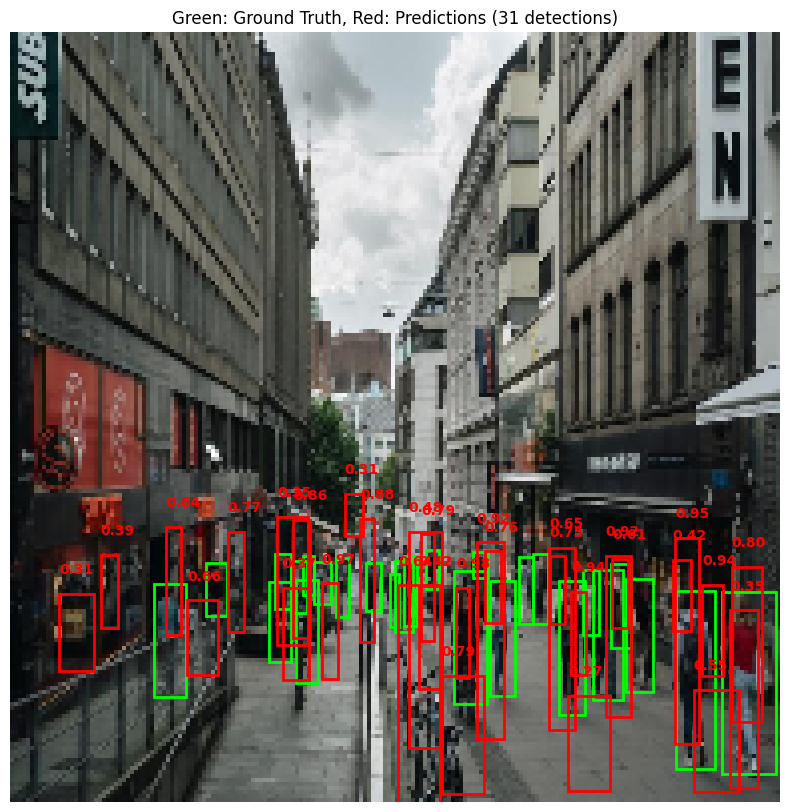

Ground truth boxes: 26
Predicted boxes: 31


In [141]:
# Plot
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(img_np)  # matplotlib handles [0, 1] float range

# Draw ground truth boxes (green)
# Note: label shape is [N, 5] with (class, cx, cy, w, h) - no batch_idx
for lbl in label:
    cx = lbl[1].item() * IMG_WIDTH
    cy = lbl[2].item() * IMG_HEIGHT
    w = lbl[3].item() * IMG_WIDTH
    h = lbl[4].item() * IMG_HEIGHT
    x = cx - w / 2
    y = cy - h / 2
    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='lime', facecolor='none')
    ax.add_patch(rect)

# Draw predicted boxes (red)
for pred in pred_boxes:
    x1, y1, x2, y2, conf, cls = pred
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    ax.text(x1, y1-5, f'{conf:.2f}', color='red', fontsize=10, fontweight='bold')

ax.set_title(f"Green: Ground Truth, Red: Predictions ({len(pred_boxes)} detections)")
ax.axis('off')
plt.show()

print(f"Ground truth boxes: {len(label)}")
print(f"Predicted boxes: {len(pred_boxes)}")

In [142]:
# Save test image as NumPy array
np.savez(
    TEST_SAMPLE_NPZ_PATH,
    image=img.numpy(),          # shape (3, 192, 192), float32, range [0,1]
    label=label.numpy(),        # ground truth boxes
    pt_out0=outputs[0].cpu().numpy(),  # shape (1, 18, 6, 6)
    pt_out1=outputs[1].cpu().numpy(),  # shape (1, 18, 12, 12)
)
print("Test image and PyTorch reference outputs saved")

Test image and PyTorch reference outputs saved


In [143]:
# Get image as numpy array: (3, H, W) in [0, 1] range (CHW format from PyTorch)
sample_img = img.numpy()

# Convert CHW to HWC format to match firmware's image_rgb565_to_rgb888() output
# From (3, 192, 192) to (192, 192, 3)
sample_img_hwc = np.transpose(sample_img, (1, 2, 0))

# Convert to uint8 [0, 255] range
sample_img_uint8 = (sample_img_hwc * 255).astype(np.uint8)

# Generate header comment with expected outputs
c_code = """/**
 * Static test input for person detection model
 *
 * Image: RGB, 192x192
 * Format: HWC (height, width, channels) - matches firmware camera output
 * Values: 0-255 (uint8)
 *
 * Expected detections (from PyTorch model):
"""

for i, pred in enumerate(pred_boxes):
    x1, y1, x2, y2, conf, cls = pred
    c_code += f" *   Box {i}: ({x1:.1f}, {y1:.1f}) to ({x2:.1f}, {y2:.1f}), conf={conf:.4f}\n"
if len(pred_boxes) == 0:
    c_code += " *   No detections\n"

c_code += """ */

#include <stdint.h>

/* Image dimensions */
#define TEST_IMG_WIDTH 192
#define TEST_IMG_HEIGHT 192
#define TEST_IMG_CHANNELS 3
#define TEST_INPUT_SIZE (TEST_IMG_WIDTH * TEST_IMG_HEIGHT * TEST_IMG_CHANNELS)

/* Input data (RGB, HWC format, uint8) */
const uint8_t test_input[TEST_INPUT_SIZE] = {"""

# Add pixel values - flatten HWC array (row by row, RGB interleaved)
flat_data = sample_img_uint8.flatten()
for i, val in enumerate(flat_data):
    if i % 16 == 0:
        c_code += "\n    "
    c_code += f"{val:3d}, "
c_code += "\n};"

# Save to file
with open(TEST_SAMPLE_H_PATH, 'w') as f:
    f.write(c_code)

print(f"Saved test sample to: {TEST_SAMPLE_H_PATH}")
print(f"File size: {len(c_code):,} characters")
print(f"Image data: {len(flat_data):,} bytes")

Saved test sample to: /content/test_sample.h
File size: 589,842 characters
Image data: 110,592 bytes


## Test Quantization

Run the test sample through the quantized TFLite model file and check the raw outputs against the PyTorch raw outputs. Expect some slight variance, as the quantization process introduces some errors/noise in the model. You can also compare these outputs to the ones generated by the microcontroller code.

In [144]:
# Compare TFLite INT8 outputs with PyTorch FP32
results = run_tflite_inference(
    tflite_path=TFLITE_PATH,
    test_npz_path=TEST_SAMPLE_NPZ_PATH,
)

# Convert HWC numpy -> NCHW tensors for decode_predictions
tflite_outputs = [
    torch.tensor(results["outputs"]["6x6"]).permute(2, 0, 1).unsqueeze(0),   # (1, 18, 6, 6)
    torch.tensor(results["outputs"]["12x12"]).permute(2, 0, 1).unsqueeze(0),  # (1, 18, 12, 12)
]

# Decode predictions and apply NMS
tflite_predictions = decode_predictions(
    tflite_outputs,
    anchors=anchors,
    anchor_masks=anchor_masks,
    img_size=IMG_HEIGHT,
    conf_thresh=0.25
)
tflite_pred_boxes = nms(tflite_predictions[0], iou_thresh=0.45)

# Print raw outputs with decoded boxes
print_raw_outputs(
    outputs_6x6=results["outputs"]["6x6"],
    outputs_12x12=results["outputs"]["12x12"],
    format="hwc",
    predictions=tflite_pred_boxes,
)

# Per-grid quantization error vs PyTorch
print("\nQuantization error vs PyTorch FP32:")
for grid, stats in results["comparison"].items():
    print(f"  {grid}: MSE={stats['mse']:.4f}, max_diff={stats['max_diff']:.4f}")


Output format: [y, x][anchor] tx    ty      tw      th      obj     cls

Output0 (6x6 grid) - first 4 cells:
  [0,0][a=0]   2.805  -0.076  -0.682  -1.062  -5.687   2.805
  [0,0][a=1]  -1.365  -1.592  -0.910  -0.227  -6.293  -0.758
  [0,0][a=2]   1.062  -1.213  -1.441  -0.758  -5.990   4.928
  [0,1][a=0]   2.881  -0.152  -0.682  -1.213  -6.066   3.185
  [0,1][a=1]  -1.744  -1.213  -1.062  -0.303  -6.900  -0.834
  [0,1][a=2]   0.910  -1.365  -1.516  -0.910  -6.445   4.853
  [0,2][a=0]   2.881  -0.379  -0.834  -1.289  -7.051   3.260
  [0,2][a=1]  -1.516  -1.365  -1.365  -0.455  -7.127  -0.607
  [0,2][a=2]   1.516  -0.910  -1.441  -1.289  -6.824   4.853
  [0,3][a=0]   2.275  -0.303  -0.834  -1.137  -6.976   2.805
  [0,3][a=1]  -1.668  -1.365  -1.516  -0.227  -7.431  -0.986
  [0,3][a=2]   1.441  -0.910  -1.137  -1.137  -6.976   3.943

Output1 (12x12 grid) - first 4 cells:
  [0,0][a=0]   0.973   1.571   0.000  -0.150  -6.360   1.048
  [0,0][a=1]   1.347  -1.945  -0.374  -1.197  -6.959   2.3

## Deploy!

Download your *model.onnx* and *model.onnx.data* files along with the *calibration_data.npz* file. Use your vendor's toolset (e.g. RUHMI) to quantize, compress, and compile the model for your target device.